# Card Classification

Dataset bertujuan untuk klasifikasi 53 kartu remi

## Load data and initial config

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from skimage.feature import hog, local_binary_pattern

In [2]:
train_data_dir = './train/'
test_data_dir = './test/'
valid_data_dir = './valid/'
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    # valid dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = create_df(train_data_dir, valid_data_dir, test_data_dir)

## EDA (Exploratory Data Analysis)

In [3]:
def plot_label_count (df, column, xaxis_label, yaxis_label, plot_title):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>53:
        print('The number of labels is >53, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        plt.show()

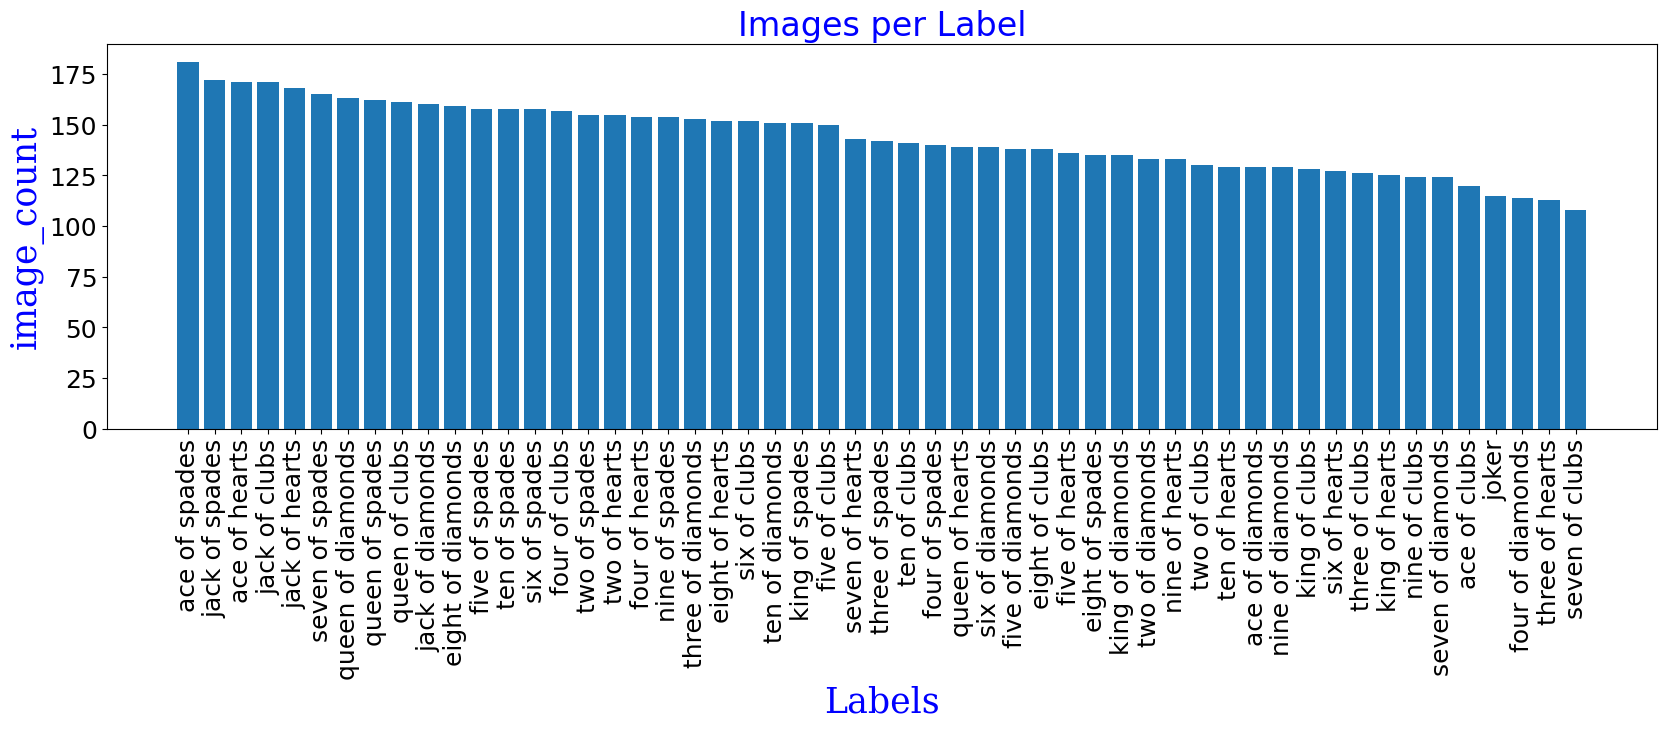

In [4]:
xaxis_label='Labels'
yaxis_label= 'image_count'
plot_title='Images per Label'
plot_label_count (train_df, 'labels', xaxis_label, yaxis_label, plot_title)

In [5]:
cv2.imread('/content/test/five of clubs/1.jpg')

## Preprocessing Data

In [6]:
# def reduce_noise_each_image(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#     img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     cv2.imwrite(df['filepaths'][i], img_output)
#   return df

#   train_df=reduce_noise_each_image(train_df)
#   valid_df=reduce_noise_each_image(valid_df)
#   test_df=reduce_noise_each_image(test_df)

In [7]:
# def preprocess_canny(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     edges = cv2.Canny(img,100,200)
#     cv2.imwrite(df['filepaths'][i], edges)
#   return df

# train_df=preprocess_canny(train_df)
# valid_df=preprocess_canny(valid_df)
# test_df=preprocess_canny(test_df)


## LBP Feature Extraction

In [8]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import tqdm

image_histograms = []
labels = []

sift = cv2.SIFT_create()

all_descriptors = []
for i in tqdm.tqdm(range(len(train_df))):
    image_path = train_df['filepaths'][i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
      all_descriptors.append(descriptors)
      labels.append(train_df['labels'][i])

all_descriptors = np.vstack(all_descriptors)
all_descriptors.shape

100%|██████████| 7624/7624 [01:03<00:00, 119.91it/s]


(1573033, 128)

In [9]:
# clustering k-means
k = 100
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)
image_histograms = []

for i in tqdm.tqdm(range(len(train_df))):
    image_path = train_df['filepaths'][i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
      words = kmeans.predict(descriptors)
      histogram, _ = np.histogram(words, bins=np.arange(k+1))
      image_histograms.append(histogram)

X_train = np.array(image_histograms)
y_train = np.array(labels)

print(X_train.shape)
print(y_train.shape)

100%|██████████| 7624/7624 [01:47<00:00, 70.61it/s]

(7624, 100)
(7624,)


In [10]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

image_histograms = []
labels = []

sift = cv2.SIFT_create()

all_descriptors = []
for i in tqdm.tqdm(range(len(test_df))):
    image_path = test_df['filepaths'][i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
      all_descriptors.append(descriptors)
      labels.append(test_df['labels'][i])

all_descriptors = np.vstack(all_descriptors)
all_descriptors.shape

100%|██████████| 265/265 [00:02<00:00, 129.29it/s]


(63587, 128)

In [11]:
# clustering k-means
k = 100
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)
image_histograms = []

for i in tqdm.tqdm(range(len(test_df))):
    image_path = test_df['filepaths'][i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
      words = kmeans.predict(descriptors)
      histogram, _ = np.histogram(words, bins=np.arange(k+1))
      image_histograms.append(histogram)

X_test = np.array(image_histograms)
y_test = np.array(labels)

print(X_test.shape)
print(y_test.shape)

100%|██████████| 265/265 [00:03<00:00, 74.47it/s]

(265, 100)
(265,)


## Training Random Forest LBP

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 123,
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
test_acc_rf = np.mean(y_pred_rf == y_test)
print(f"Random Forest Accuracy: {test_acc_rf * 100:.2f}%")

Random Forest Accuracy: 4.15%


In [13]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [ ]:
from xgboost import XGBClassifier

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'merror',
    'eta': 0.1,
    'max_depth': 53,
    'min_child_weight': 1,
    'gamma': 0.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 123,
    'n_estimators': 100,
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
test_acc_xgb = np.mean(y_pred_xgb == y_test)
print(f"XGBoost Accuracy: {test_acc_xgb * 100:.2f}%")

XGBoost Accuracy: 1.51%


## Training AUTOML Model

In [15]:
classes, counts = np.unique(y_train, return_counts=True)
print("Classes:", classes)
print("Counts per class:", counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Counts per class: [120 129 171 181 138 159 152 135 150 138 136 158 157 114 154 140 171 160
 168 172 115 128 135 125 151 124 129 133 154 161 163 139 162 108 124 143
 165 152 139 127 158 141 151 129 158 126 153 113 142 130 133 155 155]


In [17]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [18]:
from tpot import TPOTClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

# xgboost_config = {
#     'xgboost.XGBClassifier': {
#         'learning_rate': [0.01, 0.1, 0.2, 0.3],
#         'n_estimators': [50, 100, 200, 300],
#         'max_depth': [3, 5, 7, 9],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.3],
#         'scale_pos_weight': [1, 2, 3],
#         'reg_alpha': [0, 0.1, 0.5, 1],
#         'reg_lambda': [0.5, 1, 1.5],
#     }
# }

# # Create a TPOTClassifier instance
# tpot = TPOTClassifier(
#     generations=5,  # Number of iterations for optimization
#     population_size=20,  # Number of pipelines per generation
#     verbosity=2,  # Level of logging verbosity
#     config_dict=xgboost_config,  # Use the custom config for XGBoost
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

rf_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
}

# Create a TPOTClassifier instance
tpot = TPOTClassifier(
    generations=5,  # Number of iterations for optimization
    population_size=20,  # Number of pipelines per generation
    verbosity=2,  # Level of logging verbosity
    config_dict=rf_config,  # Use the custom config for Random Forest
    random_state=42,
    n_jobs=-1  # Use all available cores
)

tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))

d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


is_classifier


d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


                                                                              
Generation 1 - Current best internal CV score: 0.303512929736242
                                                                             
Generation 2 - Current best internal CV score: 0.303512929736242
                                                                             
Generation 3 - Current best internal CV score: 0.30430041736586205
                                                                             
Generation 4 - Current best internal CV score: 0.30430041736586205
                                                                              
Generation 5 - Current best internal CV score: 0.30430041736586205
                                                                              
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300)
0.022641509433962263


In [26]:
tpot.fitted_pipeline_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        min_samples_leaf=2, n_estimators=300,
                                        random_state=42))])

## Evaluate

TPOT Accuracy: 2.26%


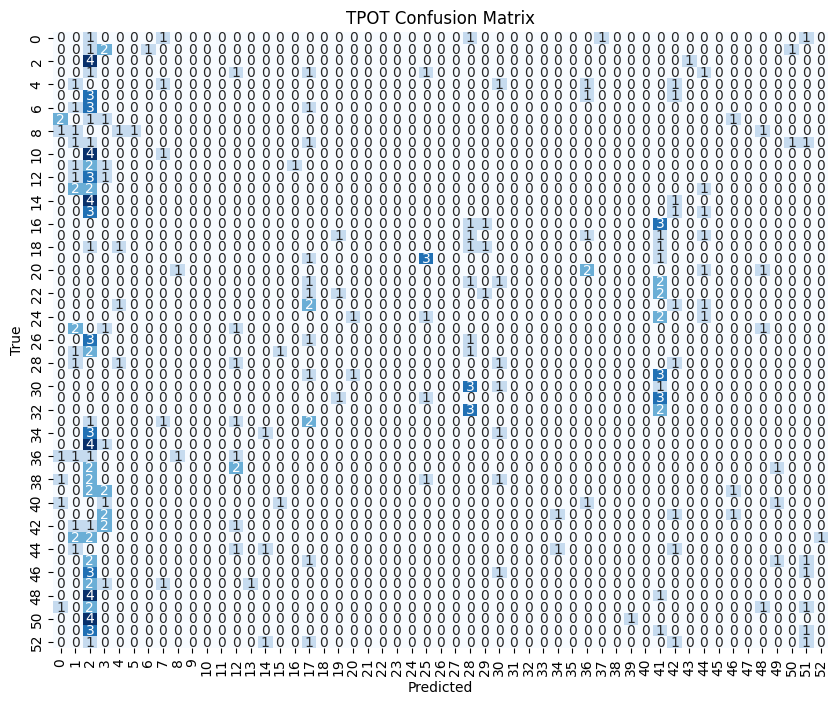

In [27]:
from sklearn.metrics import confusion_matrix

y_pred_tpot = tpot.predict(X_test)
test_acc_tpot = np.mean(y_pred_tpot == y_test)
print(f"TPOT Accuracy: {test_acc_tpot * 100:.2f}%")

conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)

# Plot confusion matrix for TPOT with label name on label dict
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tpot, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# ts_length = len(test_df)
# test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size
# train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
# valid_score = model.evaluate(valid_generator, steps= test_steps, verbose= 1)
# test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

# print("Train Loss: ", train_score[0])
# print("Train Accuracy: ", train_score[1])
# print('-' * 20)
# print("Validation Loss: ", valid_score[0])
# print("Validation Accuracy: ", valid_score[1])
# print('-' * 20)
# print("Test Loss: ", test_score[0])
# print("Test Accuracy: ", test_score[1])

In [22]:
# y_true=test_generator.labels
# y_pred= []
# preds=model.predict(test_generator, verbose=1)
# classes=list(test_generator.class_indices.keys())
# class_count=len(classes)
# for i, p in enumerate(preds):
#     pred_index=np.argmax(p)
#     true_index=test_generator.labels[i]
#     y_pred.append(pred_index)

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(18, 11))
# sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
# plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
# plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
# print("Classification Report:\n----------------------\n", clr)

In [23]:
# one_img = cv2.imread('/content/test/five of clubs/1.jpg')
# label = list(train_generator.class_indices.keys())
# plt.imshow(one_img)
# plt.show()
# one_img = one_img/255
# one_img = np.expand_dims(one_img, 0)
# one_pred = model.predict(one_img)
# one_pred = np.argmax(one_pred)
# print("Predicted label:",label[one_pred])

## Save model

In [24]:
# class_dict = train_generator.class_indices
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# subject = 'Cards-Classification'
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join('/content/drive/MyDrive/Dataset/Card-classification/', csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [25]:
# loss, accuracy = model.evaluate(test_generator)
# name = f"CardClassification-MobileNet-(224x224)-{(accuracy*100):.2f}.h5"
# model.save(f'/content/drive/MyDrive/Dataset/Card-classification/{name}')
# print(f"Model saved as {name} in /content/drive/MyDrive/Dataset/Card-classification")